In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from embeddings import get_glove_embedding_matrix, sentence_to_indexes
from emb_path import glove_6B_50d_path
from gem import GEM
from scipy.stats import pearsonr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def read_sts(path):
    df = pd.read_csv(path, sep='\n', header=None, names=['row'])
    df = pd.DataFrame(df.row.str.split('\t', 6).tolist(), columns=['', 'genre','filename','year','score','sentence1','sentence2'])
    df.drop(df.columns[[0,1,2,3]], inplace=True, axis=1)
    df["score"] = pd.to_numeric(df["score"])
    return df

In [3]:
sts_train = read_sts('data/sts_benchmark/sts-train.csv')
sts_dev = read_sts('data/sts_benchmark/sts-dev.csv')
sts_test = read_sts('data/sts_benchmark/sts-test.csv')

In [4]:
sts_train.shape, sts_dev.shape, sts_test.shape

((5749, 3), (1500, 3), (1379, 3))

In [5]:
sts_train.head()

,score,sentence1,sentence2
0,5.00,A plane is taking off.,An air plane is taking off.
1,3.80,A man is playing a large flute.,A man is playing a flute.
2,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.60,Three men are playing chess.,Two men are playing chess.
4,4.25,A man is playing the cello.,A man seated is playing the cello.


In [6]:
%%time
e, v = get_glove_embedding_matrix(glove_6B_50d_path)
sentences_inds = []
for sent in sts_train.sentence1.values.tolist():
    sentences_inds.append(sentence_to_indexes(sent, v))
for sent in sts_train.sentence2.values.tolist():
    sentences_inds.append(sentence_to_indexes(sent, v))

CPU times: user 7.21 s, sys: 366 ms, total: 7.58 s
Wall time: 7.64 s


In [7]:
%%time
gem = GEM(sentences_inds, e)
gem_result = gem.get_sentence_embeddings()

CPU times: user 50 s, sys: 269 ms, total: 50.3 s
Wall time: 26.4 s


In [8]:
def pred(ind):
    n1 = sts_train.shape[0]
    x = gem_result[:, ind]
    y = gem_result[:, n1+ind]
    x /= np.linalg.norm(x)
    y /= np.linalg.norm(y)
    return x.dot(y)

In [9]:
%%time
sts_train['pred'] = sts_train.apply(lambda row: pred(row.name), axis=1)

CPU times: user 384 ms, sys: 4.38 ms, total: 389 ms
Wall time: 312 ms


In [10]:
sts_train.corr()

,score,pred
score,1.000000,0.261268
pred,0.261268,1.000000


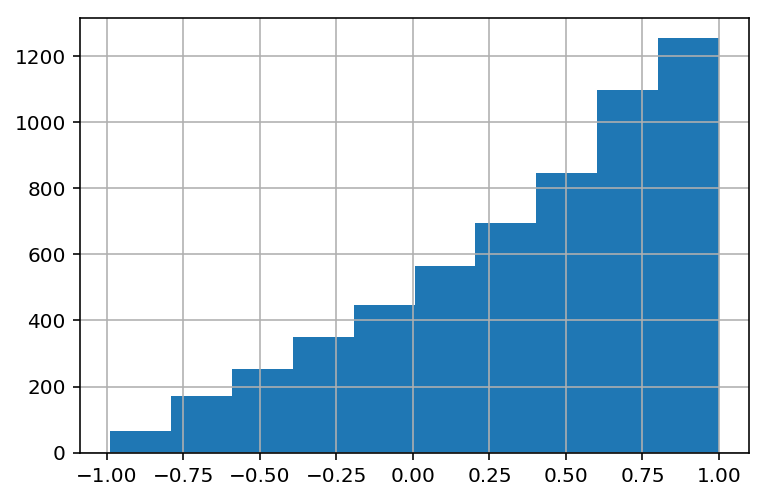

In [11]:
sts_train.pred.hist()